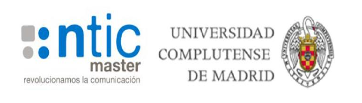

# NLP Deceitful Review Detection on e-Commerce and Social Media (2020)

This work is part of the final work to the <b>Master of Big Data and Business Analytics of the University Complutense of Madrid. 2019 - 2020.</b>



Authors: Marta Roig Atienza, Alejandra Lloret Calvo, Juan Pablo Guerrero Ortiz, Laura Débora Fernández Basquero, Ainhoa Rodrigo Bolea, Cristian Fernando Rodríguez Saldarriaga


# XGBoost Model

<b> Libraries </b> 

In [1]:
# Varios
# ------------------------------------------------------------------------------
import os.path
import logging
from sinfo import sinfo
import re
import string
import math
import xgboost as xgb # model

# Tratamiento de textos
# ------------------------------------------------------------------------------
from scipy import sparse
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

# Tratamiento de datos
# ------------------------------------------------------------------------------
import pandas as pd
import numpy as np

# Preprocesado y modelado
# ------------------------------------------------------------------------------
# ----------- gensim ----------
import gensim
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from gensim.sklearn_api import TfIdfTransformer
from gensim.test.utils import common_corpus, common_dictionary
from gensim import models, corpora, matutils

# ----------- sklearn ----------
from sklearn import model_selection
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import cufflinks
import plotly.express as px
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

C:\Users\juang\Anaconda3\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\juang\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Definition Functions

### Loading Data 

In [2]:
def read_data(filename, sep=','):
    """
        filename: path dataSet
        sep: separator text     

        return: data
    """
    data = pd.read_csv(filename, sep=sep, encoding='utf-8')
    return data


def parse_label(label):
    """
        label: convert parse label to fake: 1 and real: 0    

        return: label in 1 and 0
    """
    if label == 'true':
        return 1  # 'real or true'
    else:
        return 0  # 'fake'

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

### Embedding Models

In [3]:
def load_embedding_model(type_embedding, file_location):
    """
        Load your favourite embedding pre-trained model and it will be used to vectorize the words 
        Do not forget that you could choose the lenght vector of the pre-trained model. Your selection could be 
        between the next two options and vectors lengths:

         - Glove Files: 
            glove.6B.50d.txt
            glove.6B.100d.txt
            glove.6B.200d.txt
            glove.6B.300d.txt

        - word2vec Files:
            GoogleNews-vectors-negative300.bin.gz
            firebase-vectors-1000d.bin

        Parameters:
        type_embedding: Choose between 1 or 2 to apply load file function, correctly.
            1: Word2vec Files
            2: Glove Files

        Return embedding model
    """

    # Loading Embedding Model -> Word2Vec
    if type_embedding == 1:
        print("Loading Embedding Model")
        # Load the input-hidden weight matrix from the original C word2vec-tool format.
        w2v_model = KeyedVectors.load_word2vec_format(
            str(file_location), binary=True)
        # If replace is set, forget the original vectors and only keep the normalized ones = saves lots of memory!
        w2v_model.init_sims(replace=True)
        
        # Validate the length of the vocabulary
        if len(w2v_model.vocab) != 0:
            print("Vocabulary vectors loaded!")
            # return embedding model
            print(w2v_model)
            return w2v_model
        else:
            return print('Cannot create model!')

    # Loading Embedding Model -> Glove
    elif type_embedding == 2:
        print("Loading Embedding Model")
        # Paths
        glove_input_file = str(file_location)
        glove_output_file = (glove_input_file + '.word2vec')
        # Convert `glove_input_file` in GloVe format to word2vec format and write it to `word2vec_output_file`.
        glove2word2vec(glove_input_file, glove_output_file)
        
        # Validation exist file
        if os.path.isfile(glove_output_file):
            print("Vocabulary vectors loaded!")
            # Load the input-hidden weight matrix from the original C word2vec-tool format.
            glove_model = KeyedVectors.load_word2vec_format(
                glove_output_file, binary=False)
            # If replace is set, forget the original vectors and only keep the normalized ones...
            glove_model.init_sims(replace=True)
            # return embedding model
            print(glove_model)
            return glove_model
        else:
            return print('File not exist "word2vec_output_file"...cannot create model!')

In [4]:
def word_averaging(embedding_model, words):
    """
         embedding_model: embedding pre-trained model 
         words:     

         return: mean
     """
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in embedding_model.vocab:
            mean.append(embedding_model.syn0norm[embedding_model.vocab[word].index])
            all_words.add(embedding_model.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(embedding_model.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    
    return mean

def  word_averaging_list(embedding_model, text_list):
    """
         embedding_model: embedding pre-trained model
         text_list:     

         return: The array formed by stacking the given arrays, will be at least 2-D.
     """
    return np.vstack([word_averaging(embedding_model, post) for post in text_list])

### Feature Vector

In [5]:
def feature_vector(type_vect, x_train, x_test, text_review, set_columns =[], 
                   embedding_model = 0, ngram_range =(2, 2)):
    """
        type_vect: creation vector type
            1: TF-IDF
            2: CountVectorizer
            3: N-Grams
            4: Word2vec
            5: Glove
        x_train, x_test — samples
        text_review: text to be converted into a set of numbers (vectorization)
        set_columns: different columns to be added to the model
        embedding_model: embedding pre-trained model
        range_ngram: represent all combinations of words of length n in your text (bigram, trigram, four-gram)
       
        return vectorized representation of each type and vocabulary
    """
    # Create vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test sets and return the result

    # TF-IDF
    if type_vect == 1:
        tfidf_vect = TfidfVectorizer()
        # Fit
        tfidf_vect_fit = tfidf_vect.fit(x_train[text_review])
        # Transform
        tfidf_train = tfidf_vect_fit.transform(x_train[text_review])
        tfidf_test = tfidf_vect_fit.transform(x_test[text_review])

        # Validation add more features
        if len(set_columns) == 0:
            x_train_tfidf = tfidf_train
            x_test_tfidf = tfidf_test
        else:
            # csr_matrix -> Compressed Sparse Row matrix
            csr_mxTrain = sparse.csr_matrix(x_train[set_columns])
            csr_mxTest = sparse.csr_matrix(x_test[set_columns])
            # sparse.hstack -> Stack sparse matrices horizontally (column wise)
            x_train_tfidf = sparse.hstack([csr_mxTrain, tfidf_train], format="csr")
            x_test_tfidf = sparse.hstack([csr_mxTest, tfidf_test], format="csr")

        return x_train_tfidf, x_test_tfidf, tfidf_vect_fit

    # CountVectorizer
    elif type_vect == 2:
        count_vect = CountVectorizer()
        # Fit
        countVect_fit = count_vect.fit(x_train[text_review])
        # Transform
        countVect_train = countVect_fit.transform(x_train[text_review])
        countVect_test = countVect_fit.transform(x_test[text_review])

        # Validation add more features
        if len(set_columns) == 0:
            x_train_countVect = countVect_train
            x_test_countVect = countVect_test

        else:
            # csr_matrix -> Compressed Sparse Row matrix
            csr_mxTrain = sparse.csr_matrix(x_train[set_columns])
            csr_mxTest = sparse.csr_matrix(x_test[set_columns])
            # sparse.hstack -> Stack sparse matrices horizontally (column wise)
            x_train_countVect = sparse.hstack([csr_mxTrain, countVect_train], format="csr")
            x_test_countVect = sparse.hstack([csr_mxTest, countVect_test], format="csr")

        return x_train_countVect, x_test_countVect, countVect_fit

    # N-Grams
    elif type_vect == 3:
        ngram_vect = CountVectorizer(ngram_range=ngram_range)
        # Fit
        ngram_vect_fit = ngram_vect.fit(x_train[text_review])
        # Transform
        ngram_train = ngram_vect_fit.transform(x_train[text_review])
        ngram_test = ngram_vect_fit.transform(x_test[text_review])

        # Validation add more features
        if len(set_columns) == 0:
            x_train_ngram = ngram_train
            x_test_ngram = ngram_test
        else:
            # csr_matrix -> Compressed Sparse Row matrix
            csr_mxTrain = sparse.csr_matrix(x_train[set_columns])
            csr_mxTest = sparse.csr_matrix(x_test[set_columns])
            # sparse.hstack -> Stack sparse matrices horizontally (column wise)
            x_train_ngram = sparse.hstack([csr_mxTrain, ngram_train], format="csr")
            x_test_ngram = sparse.hstack([csr_mxTest, ngram_test], format="csr")

        return x_train_ngram, x_test_ngram, ngram_vect_fit
    
    # Word2vec
    elif type_vect == 4:
    
        # Apply word_averaging_list and convert to Compressed Sparse Row matrix
        x_train_word_average = word_averaging_list(embedding_model, x_train[text_review])
        x_train_word_average = sparse.csr_matrix(x_train_word_average)
        x_test_word_average = word_averaging_list(embedding_model, x_test[text_review])
        x_test_word_average = sparse.csr_matrix(x_test_word_average)

        # Validation add more features
        if len(set_columns) == 0:
            x_train_word2vec = x_train_word_average
            x_test_word2vec = x_test_word_average
        else:
            # Compressed Sparse Row matrix
            csr_mxTrain = sparse.csr_matrix(x_train[set_columns])
            csr_mxTest = sparse.csr_matrix(x_test[set_columns])
            # Stack sparse matrices horizontally (column wise)
            x_train_word2vec = sparse.hstack([csr_mxTrain, x_train_word_average], format="csr")
            x_test_word2vec = sparse.hstack([csr_mxTest, x_test_word_average], format="csr")

        return x_train_word2vec, x_test_word2vec

    # Glove
    elif type_vect == 5:
        # Apply word_averaging_list and convert to Compressed Sparse Row matrix
        x_train_word_average = word_averaging_list(embedding_model, x_train[text_review])
        x_train_word_average = sparse.csr_matrix(x_train_word_average)

        x_test_word_average = word_averaging_list(embedding_model, x_test[text_review])
        x_test_word_average = sparse.csr_matrix(x_test_word_average)

        # Validation add more features
        if len(set_columns) == 0:
            x_train_glove = x_train_word_average
            x_test_glove = x_test_word_average
        else:
            # Compressed Sparse Row matrix
            csr_mxTrain = sparse.csr_matrix(x_train[set_columns])
            csr_mxTest = sparse.csr_matrix(x_test[set_columns])
            # Stack sparse matrices horizontally (column wise)
            x_train_glove = sparse.hstack([csr_mxTrain, x_train_word_average], format="csr")
            x_test_glove = sparse.hstack([csr_mxTest, x_test_word_average], format="csr")

        return x_train_glove, x_test_glove

### Classifier: Train Model

In [6]:
def train_classifier_xgb_CV(feature_vector_train, y_train, parameters, folds, random_state, shuffle, name_vector,
                            scoring='accuracy', iid='deprecated',
                            refit=True, verbose=0, pre_dispatch='2*n_jobs',
                            error_score=math.nan, return_train_score=False):
    """
        feature_vector_train, y_train — training data
        parameters: tunning parameters
        folds: number of groups that a given data sample is to be split into
        random_state : is the seed used by the random number generator
        shuffle : shuffle the data before splitting into batches
        name_vector: name of the vector type

        return: result trained classifier with XGB and Cross-Validation
    """
    # K-folds
    kfold = model_selection.KFold(n_splits=folds, random_state=random_state, shuffle=shuffle)
    # Model
    xgb_classifier = xgb.XGBClassifier(n_jobs=-1)
    # Grid search
    grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=parameters, cv=kfold,
                               scoring=scoring, n_jobs=-1, iid=iid,
                               refit=refit, verbose=verbose, pre_dispatch=pre_dispatch,
                               error_score=error_score, return_train_score=return_train_score)
    # CrossValidation
    cv_fit = grid_search.fit(feature_vector_train, y_train)
    # Results CV
    cv_result = pd.DataFrame(cv_fit.cv_results_).sort_values(
        'mean_test_score', ascending=False)[0:5]
    cv_result = cv_result.iloc[:, 4:]
    # Table results CV
    params = cv_result.columns.get_loc("params")
    table_results = cv_result.iloc[:1, params:-1]
    table_results.insert(0, "Model_Vector", name_vector)

    return cv_result, table_results

### Model Classifier: Prediction

In [7]:
def model_classifier_xgb(feature_train_vector, y_train, feature_test_vector, y_test, name_vector,
                         base_score=None, booster=None, colsample_bylevel=None,
                         colsample_bynode=None, colsample_bytree=None, gamma=None,
                         gpu_id=None, importance_type='gain', interaction_constraints=None,
                         learning_rate=None, max_delta_step=None, max_depth=None,
                         min_child_weight=None, missing=math.nan, monotone_constraints=None,
                         n_estimators=100, n_jobs=None, num_parallel_tree=None,
                         objective='binary:logistic', random_state=None, reg_alpha=None,
                         reg_lambda=None, scale_pos_weight=None, subsample=None,
                         tree_method=None, validate_parameters=None, verbosity=None):
    """
        feature_train_vector, y_train — training data
        feature_test_vector, y_test — testing data
        name_vector: name of the best vector 
        tunning parameters for XGBClassifier
        
        return: model fitting & predicting the test set results
    """
    # Model
    xgbClass = xgb.XGBClassifier(base_score=base_score, booster=booster, colsample_bylevel=colsample_bylevel,
                                 colsample_bynode=colsample_bynode, colsample_bytree=colsample_bytree,
                                 gamma=gamma, gpu_id=gpu_id, importance_type=importance_type,
                                 interaction_constraints=interaction_constraints, learning_rate=learning_rate,
                                 max_delta_step=max_delta_step, max_depth=max_depth,
                                 min_child_weight=min_child_weight, missing=missing,
                                 monotone_constraints=monotone_constraints,
                                 n_estimators=n_estimators, n_jobs=n_jobs, num_parallel_tree=num_parallel_tree,
                                 objective=objective, random_state=random_state, reg_alpha=reg_alpha,
                                 reg_lambda=reg_lambda, scale_pos_weight=scale_pos_weight, subsample=subsample,
                                 tree_method=tree_method, validate_parameters=validate_parameters,
                                 verbosity=verbosity)
    # Fit
    xgb_model = xgbClass.fit(feature_train_vector, y_train)

    # Predict
    y_pred = xgb_model.predict(feature_test_vector)
    y_pred_proba = xgb_model.predict_proba(feature_test_vector)[:,1]
    
    # evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)

    # Results
    precision, recall, fscore, train_support = score(
        y_test, y_pred, pos_label=0, average='binary')

    # ROC Curve
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Save test set results and accuracy into final summary table.
    records = [(name_vector, accuracy, precision,
                recall, fscore, roc_auc)]
    labels = ['Model_Vector', 'Accuracy_Test', 'Prescision_Test',
              'Recall_Test', 'F1Score_Test', 'ROC_Curve']
    df_result_test = pd.DataFrame.from_records(records, columns=labels)
    df_resultsSummary = pd.merge(
        table_summary, df_result_test, on='Model_Vector', how='left')

    # Saving the dataframe
    df_result_test.to_csv('XGB_result_test.csv')
    df_resultsSummary.to_csv('XGB_resultsSummary.csv')

    print('Prescision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(
        round(precision, 3), round(recall, 3), round(fscore, 3), round(accuracy, 3)))

    return xgb_model, y_pred

### Model Assesment

In [8]:
def model_assesment(x_test, y_test, model, y_pred, feature_test_vector):
    """
        x_test, y_test — testing data
        gbm_model, y_pred: model fit & predict
        feature_test_vector: test vectorized
        return: plots confusion matrix, ROC Curve, and classification report.
    """

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    class_label = ["real", "fake"]
    df_cm = pd.DataFrame(cm, index=class_label, columns=class_label)
    sns.heatmap(df_cm, annot=True, fmt='g', cmap="YlGnBu")
    plt.title("Confusion Matrix XGB")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.savefig('ConfusionMatrix_Model_XGB')
    plt.show() 

    # Interpretation classification_report:
    print(classification_report(y_test, y_pred))

    # ROC Curve
    y_pred_proba = model.predict_proba(feature_test_vector)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic XGB')
    plt.legend(loc="lower right")
    plt.savefig('ROC_Model_XGB')
    plt.show()

### Cross Validation Representation

In [14]:
def box_plot_cv(union_results):
    """
        union_results: tables results Cross Validation for types Vectorization

        return: box plots algorithm comparison.
    """
    df_union_results = pd.concat(union_results).sort_values(
        'mean_test_score', ascending=False)
    df_boxplot = pd.DataFrame(df_union_results.drop('params', 1))
    df_boxplot = df_boxplot.iloc[:, :-2]
    df_boxplot = df_boxplot.melt(id_vars=["Model_Vector"], var_name='Folds')
    df_boxplot.rename(columns={'value': 'Accuracy'}, inplace=True)
    cufflinks.set_config_file(offline=True)
    fig = px.box(df_boxplot, y="Accuracy", color="Model_Vector",
                 title="Algorithm Comparison")
    fig.show()

    return df_union_results, df_boxplot

## Read Data

In [22]:
#Train Data
x_train = read_data('../data/x_train_v2.csv', sep=',')
y_train = read_data('../data/y_train_v2.csv', sep=',')

# Test data
x_test = read_data('../data/x_test_v2.csv')
y_test = read_data('../data/y_test_v2.csv')

# Parse label to true = 0 and fake = 1
y_train['LABEL'] = y_train['LABEL'].apply(lambda x: parse_label(x))
y_test['LABEL'] = y_test['LABEL'].apply(lambda x: parse_label(x))

#Tokenize the text column to get the new column 'tokenized_text'
x_train['tokenized_text'] = x_train.apply(lambda r: tokenize_text(r['REVIEW_TEXT']), axis=1).values
x_test['tokenized_text'] = x_test.apply(lambda r: tokenize_text(r['REVIEW_TEXT']), axis=1).values

print(len(x_train))
print(len(x_test))
x_test[5:30:5]

15750
5250


,DOC_ID,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,ORIGINAL_REVIEW,ORIGINAL_REVIEW_TITLE,...,word_count,PUNCT,stopwords,CommonWords_count,Bigrams_count,Trigrams_count,fullReview,DL_CLASSIFICATION_bin,DL_CLASSIFICATION_con,tokenized_text
5,8575,5,0,Grocery,B007P4MADE,mehr saffron premium spanish saffron thread gr...,saffron rice,saffron rice people would call recipe persian ...,Saffron rice is what most people would call re...,Saffron Rice,...,30,1.7,38.8,4,0,0,"mehr saffron, premium spanish saffron threads ...",0,0.091794,"[saffron, rice, people, would, call, recipe, p..."
10,9668,5,1,Jewelry,B00E0IV9P8,vintage angel wing men cross pendant adjustabl...,love it,wear cross pendant every day even shower look ...,I wear this cross pendant every day Even in sh...,Love it!,...,32,2.1,52.2,5,0,0,vintage angel wing mens cross pendant adjustab...,1,0.569335,"[wear, cross, pendant, every, day, even, showe..."
15,2722,4,0,Automotive,B0012WHBSO,viair heavy duty portable compressor,work well,own cheap compressor get walmart one much good...,I've owned a few cheap compressors that I got ...,Works well,...,23,2.7,41.0,5,0,0,viair 00073 70p heavy duty portable compressor...,0,0.453202,"[own, cheap, compressor, get, walmart, one, mu..."
20,17466,5,1,Office Products,B00HNCNT0G,chalk ink marker neon set pack best chalk ink ...,great marker,first let warn instruction marker when get exc...,"First, let me warn you about the instructions ...",Great marker,...,147,7.2,46.3,17,1,0,"chalk ink markers - neon set (8-pack), best ch...",1,0.621617,"[first, let, warn, instruction, marker, when, ..."
25,6852,5,1,Electronics,B00ET3QQUW,samsungcompatible incredisonic vue series acti...,excellent value rechargeable,love fact rechargeable time watch battery add ...,"LOVE the fact they are rechargeable, over time...",Excellent value and rechargeable!,...,20,3.4,39.5,5,1,0,samsung-compatible incredisonic vue series act...,1,0.611572,"[love, fact, rechargeable, time, watch, batter..."


## Vectorization
Train vectorizers on training set and use that to transform test set.

### TF-IDF

In [44]:
textReview_tfidf = 'REVIEW_TEXT'
columnsDataSet_tfidf = ['RATING', 'VERIFIED_PURCHASE', 'polarity', 'subjectivity',
                        'word_count', 'PUNCT', 'stopwords', 'Bigrams_count', 'Trigrams_count']

vect_train_tfidf, vect_test_tfidf, tfidf_model = feature_vector(1, x_train, x_test, textReview_tfidf,
                                                   columnsDataSet_tfidf)

vect_train_tfidf

<15750x33251 sparse matrix of type '<class 'numpy.float64'>'
	with 592992 stored elements in Compressed Sparse Row format>

### CountVectorizer

In [70]:
textReview_countVect = 'REVIEW_TEXT'
columnsDataSet_countVect = ['RATING', 'VERIFIED_PURCHASE', 'polarity', 'subjectivity',
                            'word_count', 'PUNCT', 'stopwords', 'Bigrams_count', 'Trigrams_count']

vect_train_countVect, vect_test_countVect, countVect_model = feature_vector(2, x_train, x_test,
                                                           textReview_countVect, columnsDataSet_countVect)
vect_train_countVect

<15750x33251 sparse matrix of type '<class 'numpy.float64'>'
	with 592992 stored elements in Compressed Sparse Row format>

### N-GRAMS

In [46]:
textReview_ngram = 'REVIEW_TEXT'
columnsDataSet_ngram = ['RATING', 'VERIFIED_PURCHASE', 'polarity', 'subjectivity',
                        'word_count', 'PUNCT', 'stopwords', 'Bigrams_count', 'Trigrams_count']
ngram_range = (2, 2)

vect_train_ngrams, vect_test_ngrams, ngrams_model = feature_vector(3, x_train, x_test,
                                                     textReview_ngram, columnsDataSet_ngram, ngram_range)
vect_train_ngrams

<15750x354662 sparse matrix of type '<class 'numpy.float64'>'
	with 663544 stored elements in Compressed Sparse Row format>

### Word2Vec

In [20]:
# Load the embedded model
w2v_model_300 = load_embedding_model(1, "../Word2Vec/GoogleNews-vectors-negative300.bin")

Loading Embedding Model
Vocabulary vectors loaded!


In [23]:
textReview_word2vec = 'tokenized_text'
columnsDataSet_word2vec = ['RATING', 'VERIFIED_PURCHASE', 'polarity', 'subjectivity',
                           'word_count', 'PUNCT', 'stopwords', 'Bigrams_count', 'Trigrams_count']

vect_train_word2vec_300, vect_test_word2vec_300 = feature_vector(4, x_train, x_test,
                                                     textReview_word2vec, columnsDataSet_word2vec, w2v_model_300)

vect_train_word2vec_300

<15750x309 sparse matrix of type '<class 'numpy.float64'>'
	with 4832941 stored elements in Compressed Sparse Row format>

### Glove

In [47]:
# Load the embedded model
glove_model_100 = load_embedding_model(2, "../glove.6B/glove.6B.100d.txt")

Loading Embedding Model
Vocabulary vectors loaded!


In [48]:
textReview_glove = 'tokenized_text'
columnsDataSet_glove = ['RATING', 'VERIFIED_PURCHASE', 'polarity', 'subjectivity',
                        'word_count', 'PUNCT', 'stopwords', 'Bigrams_count', 'Trigrams_count']
vect_train_glove_100, vect_test_glove_100 = feature_vector(5, x_train, x_test,
                                                     textReview_glove, columnsDataSet_glove, glove_model_100)
vect_train_glove_100

<15750x109 sparse matrix of type '<class 'numpy.float64'>'
	with 1683141 stored elements in Compressed Sparse Row format>

## Explore XGBClassifier Attributes & Hyperparameters

In [49]:
print(dir(xgb.XGBClassifier))
print()
print(xgb.XGBClassifier())

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_estimator_type', '_get_param_names', '_get_tags', '_more_tags', 'apply', 'coef_', 'evals_result', 'feature_importances_', 'fit', 'get_booster', 'get_num_boosting_rounds', 'get_params', 'get_xgb_params', 'intercept_', 'load_model', 'predict', 'predict_proba', 'save_model', 'score', 'set_params']

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=

## Exploring parameter settings using GridSearchCV

In [ ]:
# Tunning parameters for the diferent vectors for the model
params_cv = {'max_depth': [3, 7, 15],
             'learning_rate': [0.01, 0.1, 1],
             'min_child_weight': [10, 15, 20],
             'n_estimators': [50, 100, 150]}
# Folds cv: number of groups that a given data sample is to be split
folds_cv = 5

### TF-IDF Vector

In [ ]:
# Name of the vector, it's important to follow the same nomenclature for your table of result
name_tfidf = "XGB_TF-IDF"
# Classifiers CV
resultCV_tfidf, table_tfidf = train_classifier_xgb_CV(vect_train_tfidf, y_train, params_cv,
                                                      folds_cv, name_vector=name_tfidf,
                                                      random_state=825, shuffle=True, verbose=1)
resultCV_tfidf

In [62]:
resultCV_tfidf = read_data('XGB_runningCV/resultCV_countVect.csv')
resultCV_tfidf

,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.1,15,10,100,"{'learning_rate': 0.1, 'max_depth': 15, 'min_c...",0.815238,0.814921,0.808889,0.814286,0.811429,0.812952,0.002438,1
1,0.1,15,15,150,"{'learning_rate': 0.1, 'max_depth': 15, 'min_c...",0.813968,0.809524,0.813016,0.811111,0.812381,0.812000,0.001547,2
2,0.1,15,10,150,"{'learning_rate': 0.1, 'max_depth': 15, 'min_c...",0.811429,0.816508,0.805714,0.814603,0.811429,0.811937,0.003667,3
3,0.1,15,15,100,"{'learning_rate': 0.1, 'max_depth': 15, 'min_c...",0.812698,0.813968,0.813333,0.807302,0.810476,0.811556,0.002431,4
4,0.1,7,20,150,"{'learning_rate': 0.1, 'max_depth': 7, 'min_ch...",0.814603,0.812381,0.806984,0.811429,0.812063,0.811492,0.002495,5


### COUNTVECTOR Vector

In [ ]:
# Name of the vector, it's important to follow the same nomenclature for your table of result
name_countVect = "XGB_CountVect"
# Classifiers CV
resultCV_countVect, table_countVect = train_classifier_xgb_CV(vect_train_countVect, 
                                                                  y_train, params_cv,
                                                                  folds_cv,  name_vector=name_countVect,
                                                                  random_state=825, shuffle=True, verbose=1)
resultCV_countVect

In [63]:
resultCV_countVect = read_data('XGB_runningCV/resultCV_countVect.csv')
resultCV_countVect

,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.1,15,10,100,"{'learning_rate': 0.1, 'max_depth': 15, 'min_c...",0.815238,0.814921,0.808889,0.814286,0.811429,0.812952,0.002438,1
1,0.1,15,15,150,"{'learning_rate': 0.1, 'max_depth': 15, 'min_c...",0.813968,0.809524,0.813016,0.811111,0.812381,0.812000,0.001547,2
2,0.1,15,10,150,"{'learning_rate': 0.1, 'max_depth': 15, 'min_c...",0.811429,0.816508,0.805714,0.814603,0.811429,0.811937,0.003667,3
3,0.1,15,15,100,"{'learning_rate': 0.1, 'max_depth': 15, 'min_c...",0.812698,0.813968,0.813333,0.807302,0.810476,0.811556,0.002431,4
4,0.1,7,20,150,"{'learning_rate': 0.1, 'max_depth': 7, 'min_ch...",0.814603,0.812381,0.806984,0.811429,0.812063,0.811492,0.002495,5


### N-GRAMS Vector

In [ ]:
# Name of the vector, it's important to follow the same nomenclature for your table of result
name_ngrams = "XGB_NGrams"
# Classifiers CV
resultCV_ngrams, table_ngrams = train_classifier_xgb_CV(vect_train_ngrams, y_train, params_cv,
                                                        folds_cv, name_vector=name_ngrams,
                                                        random_state=825, shuffle=True, verbose=1)
resultCV_ngrams

In [64]:
resultCV_ngrams = read_data('XGB_runningCV/resultCV_ngrams.csv')
resultCV_ngrams

,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.1,7,15,50,"{'learning_rate': 0.1, 'max_depth': 7, 'min_ch...",0.798730,0.804444,0.793333,0.795238,0.809206,0.800190,0.005883,1
1,0.1,7,15,100,"{'learning_rate': 0.1, 'max_depth': 7, 'min_ch...",0.796190,0.804444,0.793968,0.796190,0.809524,0.800063,0.005930,2
2,0.1,7,10,100,"{'learning_rate': 0.1, 'max_depth': 7, 'min_ch...",0.798413,0.804444,0.792698,0.793968,0.809841,0.799873,0.006461,3
3,0.1,3,15,150,"{'learning_rate': 0.1, 'max_depth': 3, 'min_ch...",0.799048,0.807937,0.792063,0.796825,0.801587,0.799492,0.005257,4
4,0.1,7,20,50,"{'learning_rate': 0.1, 'max_depth': 7, 'min_ch...",0.801587,0.801905,0.791111,0.797460,0.805079,0.799429,0.004812,5


### WORD2VEC Vector

In [ ]:
# Name of the vector, it's important to follow the same nomenclature for your table of result
name_word2vec = "XGB_Word2Vec_300"
# Classifiers CV
resultCV_word2vec_300, table_word2vec_300 = train_classifier_xgb_CV(vect_train_word2vec_300, y_train, params_cv,
                                                            folds_cv, name_vector=name_word2vec,
                                                            random_state=825, shuffle=True, verbose=1)
resultCV_word2vec_300

In [65]:
resultCV_word2vec_300 = read_data('XGB_runningCV/resultCV_word2vec_300.csv')
resultCV_word2vec_300

,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.1,15,15,150,"{'learning_rate': 0.1, 'max_depth': 15, 'min_c...",0.822857,0.808889,0.809524,0.812063,0.814286,0.813524,0.005046,1
1,0.1,15,15,100,"{'learning_rate': 0.1, 'max_depth': 15, 'min_c...",0.824444,0.812063,0.810794,0.809524,0.810794,0.813524,0.005519,2
2,0.1,7,15,150,"{'learning_rate': 0.1, 'max_depth': 7, 'min_ch...",0.821905,0.811111,0.813333,0.808254,0.811746,0.813270,0.004620,3
3,0.1,7,10,100,"{'learning_rate': 0.1, 'max_depth': 7, 'min_ch...",0.814921,0.809524,0.810159,0.813968,0.817143,0.813143,0.002893,4
4,0.1,15,15,50,"{'learning_rate': 0.1, 'max_depth': 15, 'min_c...",0.823175,0.806667,0.811746,0.807619,0.815556,0.812952,0.006011,5


### GLOVE Vector

In [ ]:
# Name of the vector, it's important to follow the same nomenclature for your table of result
name_glove = "XGB_Glove_100"
# Classifiers CV
resultCV_glove_100, table_glove_100 = train_classifier_xgb_CV(vect_train_glove_100, y_train, params_cv,
                                                 folds_cv, name_vector=name_glove,
                                                 random_state=825, shuffle=True, verbose=1)
resultCV_glove_100

In [66]:
resultCV_glove_100 = read_data('XGB_runningCV/resultCV_glove_100.csv')
resultCV_glove_100

,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.1,7,20,150,"{'learning_rate': 0.1, 'max_depth': 7, 'min_ch...",0.822857,0.811746,0.806032,0.808571,0.811429,0.812127,0.005754,1
1,0.1,7,20,100,"{'learning_rate': 0.1, 'max_depth': 7, 'min_ch...",0.819683,0.813333,0.806349,0.808571,0.812381,0.812063,0.004574,2
2,0.1,7,10,100,"{'learning_rate': 0.1, 'max_depth': 7, 'min_ch...",0.816190,0.809841,0.808889,0.813968,0.811111,0.812000,0.002704,3
3,0.1,7,15,150,"{'learning_rate': 0.1, 'max_depth': 7, 'min_ch...",0.814286,0.812063,0.807302,0.812698,0.812063,0.811683,0.002336,4
4,0.1,15,10,150,"{'learning_rate': 0.1, 'max_depth': 15, 'min_c...",0.822540,0.807937,0.805079,0.811429,0.811111,0.811619,0.005931,5


### BoxPlot

In [67]:
# boxplot algorithm comparison
union_tables = [table_tfidf, table_countVect, table_ngrams, table_word2vec, table_glove]
table_summary, bx = box_plot_cv(union_tables)
table_summary

,Model_Vector,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
0,XGB_Word2Vec_300,"{'learning_rate': 0.1, 'max_depth': 15, 'min_c...",0.822857,0.808889,0.809524,0.812063,0.814286,0.813524,0.005046
0,XGB_CountVect,"{'learning_rate': 0.1, 'max_depth': 15, 'min_c...",0.815238,0.814921,0.808889,0.814286,0.811429,0.812952,0.002438
0,XGB_TF-IDF,"{'learning_rate': 0.1, 'max_depth': 15, 'min_c...",0.811429,0.814603,0.809206,0.814286,0.813968,0.812698,0.002077
0,XGB_Glove_100,"{'learning_rate': 0.1, 'max_depth': 7, 'min_ch...",0.822857,0.811746,0.806032,0.808571,0.811429,0.812127,0.005754
0,XGB_NGrams,"{'learning_rate': 0.1, 'max_depth': 7, 'min_ch...",0.798730,0.804444,0.793333,0.795238,0.809206,0.800190,0.005883


## Best model

    According to the results of the previous parameters we will select the best tunning and the best vector to predict in the test data.

#### Model fitting & predicting the test set results and caculating the accuracy

In [68]:
# Type the best vector model and parameters
best_name_vect = 'XGB_CountVect'
best_vect_train = vect_train_countVect
best_vect_test = vect_test_countVect

# Model and Predict
xgb_model, y_pred = model_classifier_xgb(best_vect_train, y_train, best_vect_test, y_test, best_name_vect, 
                                         n_estimators=150, max_depth=15, learning_rate=0.1, min_child_weight=15,
                                         n_jobs=-1, verbosity=1)
xgb_model

Prescision: 0.847 / Recall: 0.763 / F1-Score: 0.803 / Accuracy: 0.813


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=15, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

####  Model Assesment

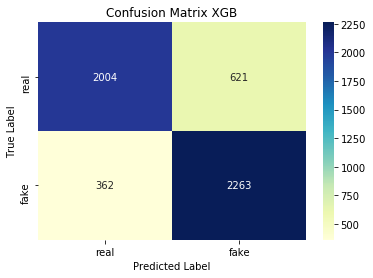

              precision    recall  f1-score   support

           0       0.85      0.76      0.80      2625
           1       0.78      0.86      0.82      2625

    accuracy                           0.81      5250
   macro avg       0.82      0.81      0.81      5250
weighted avg       0.82      0.81      0.81      5250



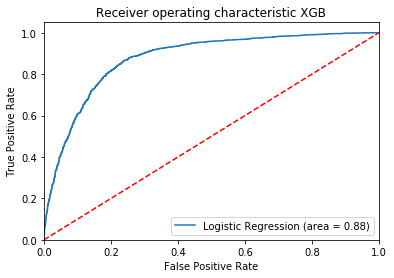

In [69]:
model_assesment(x_test, y_test, xgb_model, y_pred, best_vect_test)

#### Feature Importances

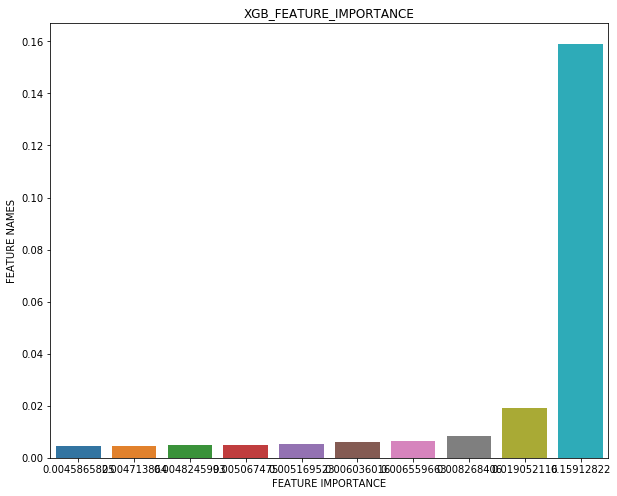

In [36]:
plot_feature_importance(vars_importance, vars_importance,  "XGB")

#### Save Model

In [73]:
import pickle
# Save to file in the current working directory
pkl_filename = "xgb_model_finalRelease_v1.0.pkl"
with open(pkl_filename, 'wb') as fout:
    pickle.dump((countVect_model, xgb_model), fout)

## Session Information

In [74]:
sinfo()

-----
cufflinks   0.17.3
gensim      3.8.3
matplotlib  3.1.3
nltk        3.4.5
numpy       1.18.1
pandas      1.1.2
plotly      4.3.0
scipy       1.4.1
seaborn     0.10.0
sinfo       0.3.1
sklearn     0.22.1
xgboost     1.1.1
-----
IPython             7.13.0
jupyter_client      6.1.0
jupyter_core        4.6.1
jupyterlab          1.1.4
notebook            6.1.1
-----
Python 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
Windows-10-10.0.18362-SP0
8 logical CPU cores, Intel64 Family 6 Model 142 Stepping 10, GenuineIntel
-----
Session information updated at 2020-09-14 16:12


__Project idea:__
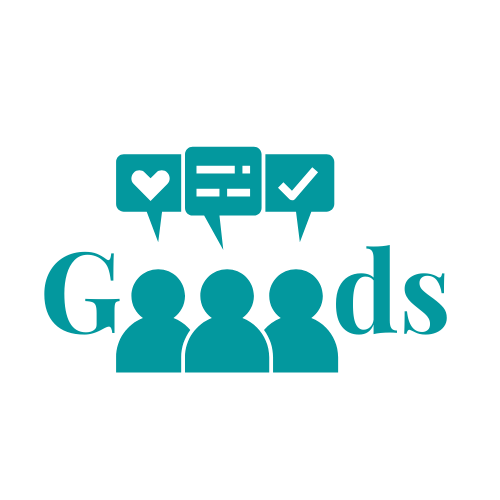


Developed by the following authors: 

 _Ainhoa Rodrigo Bolea (ainhoa2612@gmail.com)_
 
 _Alejandra Lloret Calvo (alejandralloretc@gmail.com)_
 
 _Cristian Fernando Rodríguez Saldarriaga (c.fernandoro@gmail.com)_

 _Juan Pablo Guerrero Ortiz (jguerror41@gmail.com)_ 
 
 _Laura Débora Fernández Basquero (ldfernandez09@gmail.com)_
 
 _Marta Roig Atienza (martaroigatienza@hotmail.com)_
 
 
Based on the research work: **NLP Deceitful Review Detection on e-Commerce and Social Media (2020)**

This work is part of the final master thesis to the _Master of Big Data and Business Analytics of the University Complutense of Madrid. 2019 - 2020._
